# Task 8: Fake news prediction


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from ydata_profiling import ProfileReport
from warnings import filterwarnings
from wordcloud import WordCloud

filterwarnings('ignore')
%matplotlib inline

In [2]:

df = pd.read_csv('C:\\Users\\fasil\\OneDrive\\Desktop\\internship\\cognorise-internship\\data\\raw\\news.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# Exploratory data analysis

In [3]:
print(f'Description before duplicates: {df.describe()}')
print('\n\n')


df = df.copy().drop_duplicates(subset=['text'])
print(f'Description after duplicates: {df.describe()}')

Description before duplicates:                                 title  \
count                            6335   
unique                           6256   
top     OnPolitics | 's politics blog   
freq                                5   

                                                     text label  
count                                                6335  6335  
unique                                               6060     2  
top     Killing Obama administration rules, dismantlin...  REAL  
freq                                                   58  3171  



Description after duplicates:                               title  \
count                          6060   
unique                         6011   
top     Michael Moore Owes Me $4.99   
freq                              3   

                                                     text label  
count                                                6060  6060  
unique                                               6060     2  
top   

In [4]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Overview of the dataset

In [5]:
df.head(3)

title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL

In [6]:
print(f'Data by label: {df.label.value_counts()}')

df.label = df.label.map({'REAL': 0, 'FAKE': 1})
print(df.label.unique())

Data by label: label
FAKE    3071
REAL    2989
Name: count, dtype: int64
[1 0]


# Text cleaning

In [7]:
df['text_length'] = df['text'].apply(len)
df['text_num_capital_letters'] = df['text'].apply(lambda s: sum([1 for c in s if c.isupper()]))
df['text_num_words'] = df['text'].apply(lambda s: len(s.split()))
df['text_avg_word_length'] = df['text'].apply(lambda s: sum(len(word) for word in s.split()) / len(s.split()) if len(s.split()) > 0 else 0)
df['text_num_special_chars'] = df['text'].apply(lambda s: sum([1 for c in s if not c.isalnum() and not c.isspace()]))

df.head()

title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text  label  text_length  \
0  Daniel Greenfield, a Shillman Journalism Fello...      1         7518   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...      1         2646   
2  U.S. Secretary of State John F. Kerry said Mon...      0         2543   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...      1         2660   
4  It's primary day in New York and front-runners...      0         1840   

   text_num_capital_letters  text_num_words  text_avg_word_length  \
0                       314            1296              4.776235   
1                        96             446              4.917040   
2                        96             431              4.883991   
3                       139             404              5.554455   
4                        77             317              4.776025   

   text_num_special_chars  
0                     147  
1                      78  
2                      55  
3                      98  
4                      65

In [8]:
def clean_text(text) -> str:
    """
    Cleans the input text by performing the following operations:
    - Converts the text to lowercase
    - Removes special characters
    - Removes stopwords
    - Removes URLs
    - Removes punctuation
    - Removes email addresses
    - Removes user handles

    Parameters:
    text (str): The input text to be cleaned.

    Returns:
    str: The cleaned text.
    """
    text = str(text).lower()
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_emails(text)
    text = nfx.remove_userhandles(text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.drop(['text', 'title'], axis=1, inplace=True)
df.head()

label  text_length  text_num_capital_letters  text_num_words  \
0      1         7518                       314            1296   
1      1         2646                        96             446   
2      0         2543                        96             431   
3      1         2660                       139             404   
4      0         1840                        77             317   

   text_avg_word_length  text_num_special_chars  \
0              4.776235                     147   
1              4.917040                      78   
2              4.883991                      55   
3              5.554455                      98   
4              4.776025                      65   

                                        cleaned_text  
0  daniel greenfield shillman journalism fellow f...  
1  google pinterest digg linkedin reddit stumbleu...  
2  secretary state john f kerry said monday stop ...  
3  kaydee king kaydeeking november 9 2016 lesson ...  
4  primary day new york frontrunners hillary clin...

In [9]:
df.describe()

label    text_length  text_num_capital_letters  text_num_words  \
count  6060.000000    6060.000000               6060.000000     6060.000000   
mean      0.506766    4881.384983                159.221617      805.143894   
std       0.499995    5113.741301                178.245322      858.836623   
min       0.000000       1.000000                  0.000000        0.000000   
25%       0.000000    1959.000000                 69.000000      324.000000   
50%       1.000000    3825.500000                121.000000      631.000000   
75%       1.000000    6311.500000                196.000000     1044.000000   
max       1.000000  115372.000000               3891.000000    20891.000000   

       text_avg_word_length  text_num_special_chars  
count           6060.000000             6060.000000  
mean               5.077739              145.642409  
std                0.718360              159.460259  
min                0.000000                0.000000  
25%                4.882522               55.000000  
50%                5.045942              111.000000  
75%                5.215551              185.000000  
max               48.496000             3191.000000

In [10]:
report_new_data = ProfileReport(df)
report_new_data.to_file('C:\\Users\\fasil\\OneDrive\\Desktop\\internship\\cognorise-internship\\reports\\fakenews.html')
report_new_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Model implementation

In [11]:
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
preprocess = ColumnTransformer(
    transformers=[
        ('cleaned_text', TfidfVectorizer(), 'cleaned_text'),
        ('numeric', RobustScaler(), df.columns.drop(['cleaned_text', 'label']))
    ]
)

model = RandomForestClassifier()

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('classifier', model)
])


param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [10, 20, 30, 40, 50, 60, 100, 200],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}


random_search = RandomizedSearchCV(pipeline, param_distributions, scoring='recall', cv=3, n_iter=10)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")


best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

Best parameters: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 30, 'classifier__bootstrap': False}


In [13]:
from joblib import dump

# Saving
dump(best_model, 'C:\\Users\\fasil\\OneDrive\\Desktop\\internship\\cognorise-internship\\models\\best_model-fake-news.joblib') 

['C:\\Users\\fasil\\OneDrive\\Desktop\\internship\\cognorise-internship\\models\\best_model-fake-news.joblib']

Metrics and evaluation of the model

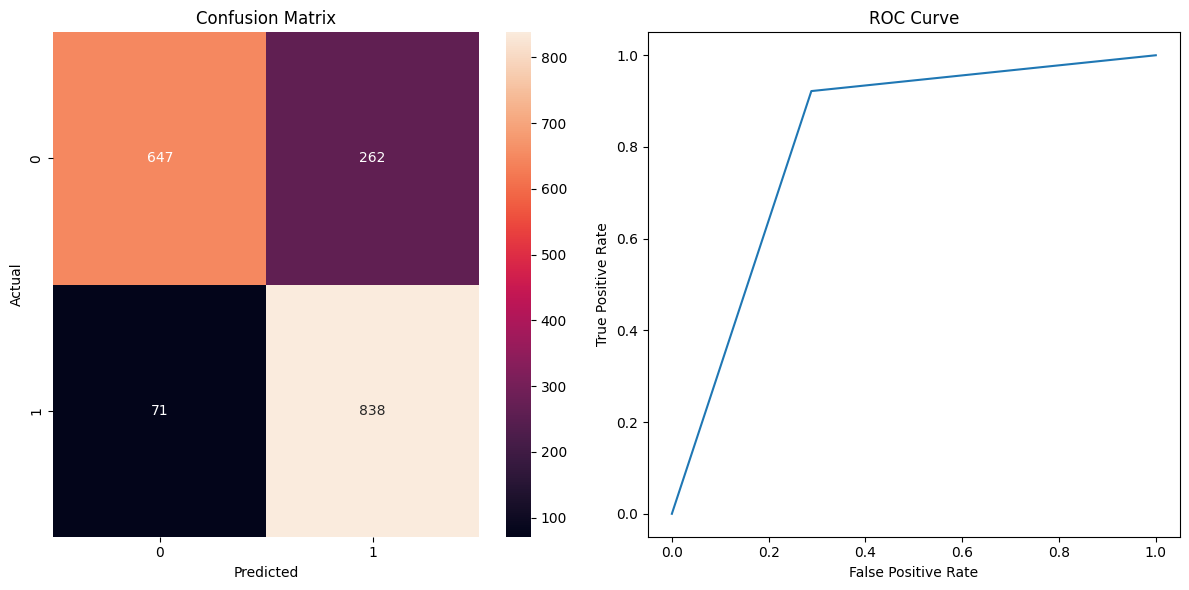

In [14]:
cm = confusion_matrix(y_test, predictions)

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

ax2.plot(fpr, tpr)
ax2.set_title('ROC Curve')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

In [15]:
train_predictions = best_model.predict(X_train)

train_report = classification_report(y_train, train_predictions)
print(f"Training Classification Report:\n{train_report}\n")

test_report = classification_report(y_test, predictions)
print(f"Testing Classification Report:\n{test_report}")

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      2080
           1       0.89      1.00      0.94      2162

    accuracy                           0.94      4242
   macro avg       0.95      0.94      0.94      4242
weighted avg       0.95      0.94      0.94      4242


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80       909
           1       0.76      0.92      0.83       909

    accuracy                           0.82      1818
   macro avg       0.83      0.82      0.81      1818
weighted avg       0.83      0.82      0.81      1818



Learning curves for the models and four different metrics for classification

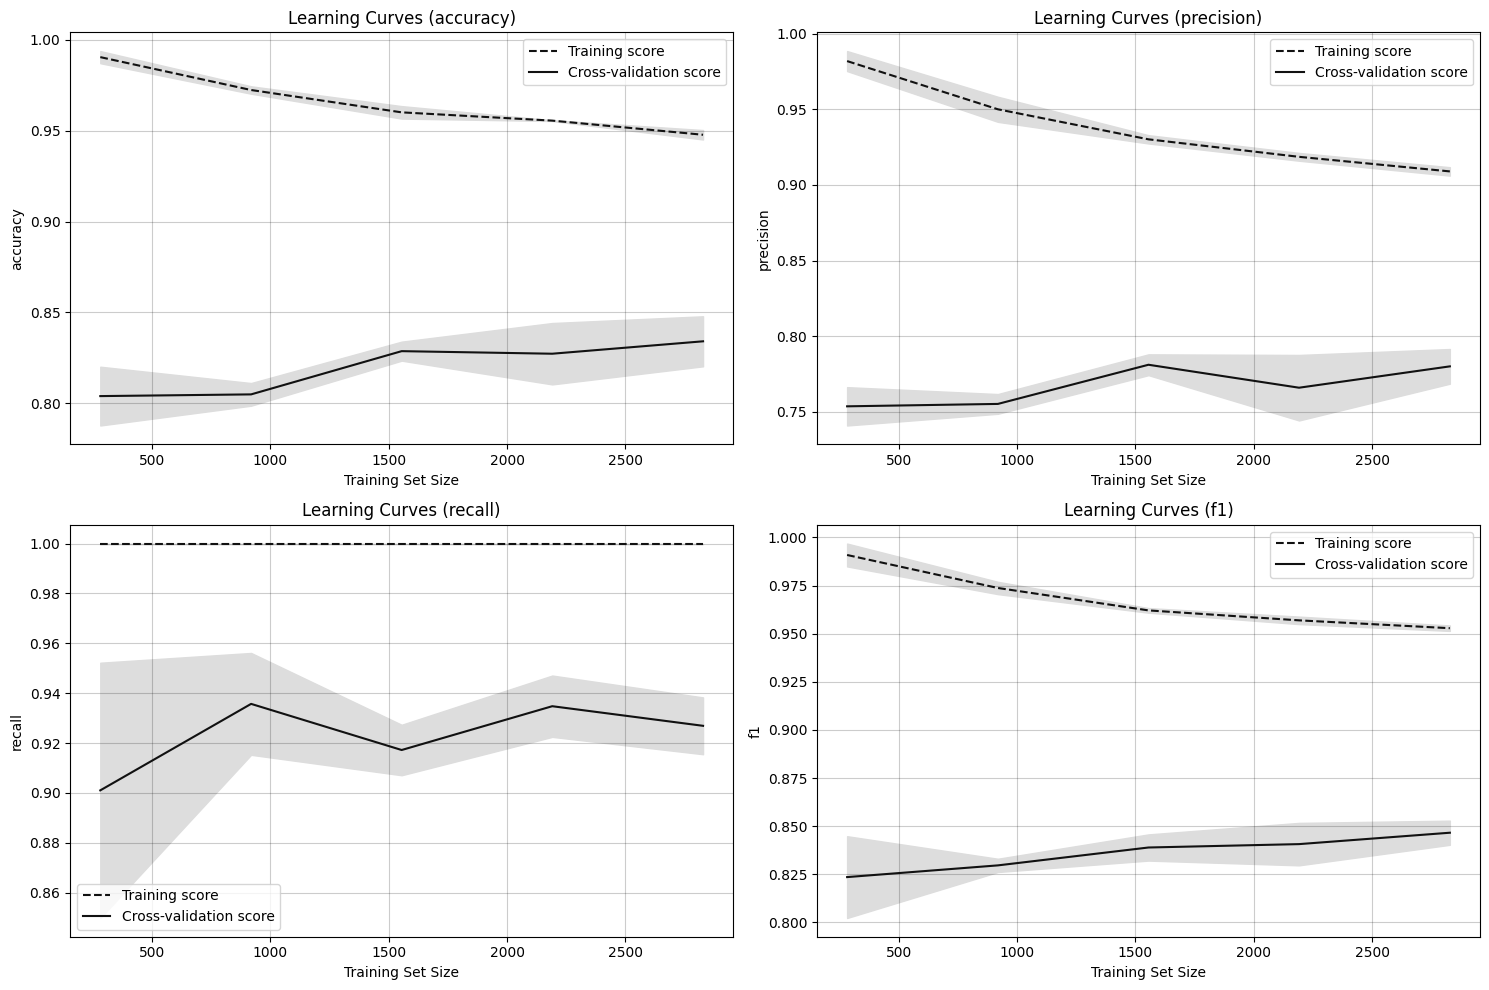

In [16]:
metrics = ['accuracy', 'precision', 'recall', 'f1']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for i, metric in enumerate(metrics):
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=3, scoring=metric)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    axs[i].plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    axs[i].plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")


    axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    axs[i].set_title(f'Learning Curves ({metric})')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel(metric)
    axs[i].legend(loc='best')
    axs[i].grid(True, alpha=0.2, color='black')

plt.tight_layout()
plt.show()

In [17]:
auc_score = roc_auc_score(y_test, predictions)
print("AUC-ROC Score:", auc_score)

log_loss_score = log_loss(y_test, predictions)
print("Log Loss:", log_loss_score)

mcc = matthews_corrcoef(y_test, predictions)
print("Matthews Correlation Coefficient:", mcc)

AUC-ROC Score: 0.8168316831683169
Log Loss: 6.602055323749181
Matthews Correlation Coefficient: 0.6481326782377552
